The lab codes are modified based on:
1. https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction
## Basic Concepts
What exactly are RNNs? First, let’s compare the architecture and flow of RNNs vs traditional feed-forward neural networks.

<img src = 'https://blog.floydhub.com/content/images/2019/04/Slide3-1.jpg' width ="100%"> </img>

(References: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

The main difference is in how the input data is taken in by the model.
Traditional feed-forward neural networks take in a fixed amount of input data all at the same time and produce a fixed amount of output each time. On the other hand, RNNs do not consume all the input data at once. Instead, they take them in one at a time and in a sequence. At each step, the RNN does a series of calculations before producing an output. The output, known as the hidden state, is then combined with the next input in the sequence to produce another output. This process continues until the model is programmed to finish or the input sequence ends.

## Output of a RNN layer
In some cases, you’ll only need one final output after passing in all the input, for instance, if you’re using the RNN for a classification task, your output is a vector representing the class probability scores. 
<img src = 'https://blog.floydhub.com/content/images/2019/04/Slide6.jpg' width ="100%"> </img>

In another case, say if you’re doing text generation based on the previous character/word, you’ll need an output at every single time step.
<img src = 'https://blog.floydhub.com/content/images/2019/04/Slide7.jpg'> </img>

(References: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

### A simple example to see the output of a RNN layer

In [ ]:
# input_size: the number of features in input
# hidden_size: the number of features in hidden states
# num_layers: RNN layers stacked 
rnn = nn.RNN(input_size = 10, hidden_size = 20, num_layers = 2, batch_first = True)

# input shape: (sequence length, batch size, input size)
input = torch.randn(3, 5, 10)

output, h_n = rnn(input)
# output shape: sequence length, batch size, hidden size
# h_n shape: number of layer, batch size, hidden size

#output contains the output features (h_t) from the last layer of the RNN, for each t.
print("output shape:", output.shape)
# if you want to only use the last output from the last element
print("last step output shape: ", output[:,-1,:].shape)  # similar to set return_sequences = False in keras

#h_n contains the final hidden state for each element in the batch. (number of layers, batch_size, hidden dim)
print("hidden state shape: ", h_n.shape)


output shape: torch.Size([3, 5, 20])
last step output shape:  torch.Size([3, 20])
hidden state shape:  torch.Size([2, 3, 20])


## Example of IMDB data
### Classification with RNN
Now let's use a RNN model to classify the IMDB reviews.

### Download and pre-process the IMDB data


In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 200  # cut texts backwards before this number of words (among top max_features most common words)


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# add 0 at the beginning of a sentence if its length <100
# we'll use the output of last word to predict the sentiment
# if padding at the end, the last word may be 0.
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen,padding='pre')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen,padding='pre')


print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [ ]:
x_train[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    1,   14,   47,    8,   30,   31,    7,
          4,  249,  108,    7,    4, 5974,   54,   61,  369,   13,   71,
        149,   14,   22,  112,    4, 2401,  311,   12,   16, 3711,   33,
         75,   43, 1829,  296,    4,   86,  320,   35,  534,   19,  263,
       4821, 1301,    4, 1873,   33,   89,   78,   12,   66,   16,    4,
        360,    7,    4,   58,  316,  334,   11,    4, 1716,   43,  645,
        662,    8,  257,   85, 1200,   42, 1228, 2578,   83,   68, 3912,
         15,   36,  165, 1539,  278,   36,   69,    2,  780,    8,  106,
         14, 6905, 1338,   18,    6,   22,   12,  2

In [ ]:
y_train[0:5]

array([1, 0, 0, 1, 0])

Define the Pyotch dataset:

In [ ]:
class IMDB_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.IntTensor(featuers)
        self.labels = torch.Tensor(labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.length

Dataset & Dataloader:

In [ ]:
# datasets
train_dataset = IMDB_dataset(x_train, y_train)
test_dataset = IMDB_dataset(x_test, y_test)

Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [ ]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, embedding_dim, output_size, hidden_dim, n_layers):
        super(RNN_Model, self).__init__()

        # Defining some parameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # Embedding Layer
        self.emb = nn.Embedding(input_size,embedding_dim,padding_idx = 0)
        # RNN Layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # linear  layer
        self.fc = nn.Linear(hidden_dim, output_size)

    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        embedding = self.emb(x)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        rnn_out, hidden_out = self.rnn(embedding)
        
        # run_out shape: [bacth_size, sequence length, hidden_dim]
        # Select which time step data you want for linear layers
        out = self.fc(rnn_out[:,-1,:])

        #or you want to use hidden_ as an input for the next layer
        #out = self.fc(hidden_out)
        
        #rnn_out = self.fc(out)
       

        
        return out
    
  

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary 

# Instantiate the model with hyperparameters
batch_size = 128

model = RNN_Model(input_size = max_features+1, embedding_dim=50, output_size=1, hidden_dim=50, n_layers=1)
summary(model,input_size=(batch_size,maxlen),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
RNN_Model                                --                        --
├─Embedding: 1-1                         [128, 200, 50]            500,050
├─RNN: 1-2                               [128, 200, 50]            5,100
├─Linear: 1-3                            [128, 1]                  51
Total params: 505,201
Trainable params: 505,201
Non-trainable params: 0
Total mult-adds (M): 194.57
Input size (MB): 0.20
Forward/backward pass size (MB): 20.48
Params size (MB): 2.02
Estimated Total Size (MB): 22.71

### Train the model

Following the procedures that were shown in Lab 3 Embedding, we build the model and define functions to implement the model.

In [ ]:
# Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device, lr=0.0005, epochs=20, batch_size=32):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
    
    return history
   


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=30,
                      batch_size=128)

Training Start
Epoch:1 / 30, train loss:0.66372 train_acc:0.58554, valid loss:0.62555 valid acc:0.64900
Epoch:2 / 30, train loss:0.60204 train_acc:0.67367, valid loss:0.60207 valid acc:0.67606
Epoch:3 / 30, train loss:0.56121 train_acc:0.71138, valid loss:0.55967 valid acc:0.71006
Epoch:4 / 30, train loss:0.51984 train_acc:0.74287, valid loss:0.55182 valid acc:0.73083
Epoch:5 / 30, train loss:0.49238 train_acc:0.76459, valid loss:0.51144 valid acc:0.75490
Epoch:6 / 30, train loss:0.47217 train_acc:0.77822, valid loss:0.50052 valid acc:0.75917
Epoch:7 / 30, train loss:0.44698 train_acc:0.79464, valid loss:0.53435 valid acc:0.76120
Epoch:8 / 30, train loss:0.42730 train_acc:0.80919, valid loss:0.48648 valid acc:0.77081
Epoch:9 / 30, train loss:0.41544 train_acc:0.81601, valid loss:0.49337 valid acc:0.77467
Epoch:10 / 30, train loss:0.39157 train_acc:0.82976, valid loss:0.46001 valid acc:0.78966
Epoch:11 / 30, train loss:0.37603 train_acc:0.84000, valid loss:0.44731 valid acc:0.79755
Epoc

The performance is under expectation. There are several causes: 
1. We didn't tune the parameters of the model. You can play with it and try to find the optimal strategy that can give you the best performance.
2. The sentences in the sample is very long. Since we only use the output for the last word of each sentence, the information of the first several words will be lost in the model's "memory". 

### Classification with LSTM

The LSTM model structure is similar to RNN model. 
Just replace the RNN layer with LSTM layer. 



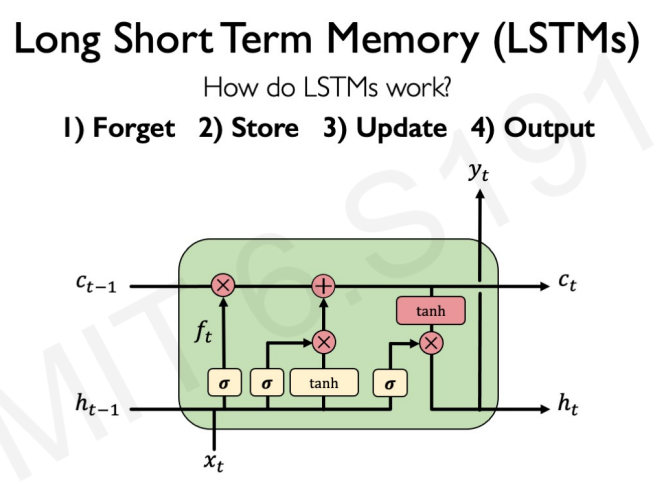

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, embedding_dim, output_size, hidden_dim, n_layers):
        super(LSTM_Model, self).__init__()

        # Defining some parameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # Embedding Layer
        self.emb = nn.Embedding(input_size,embedding_dim,padding_idx = 0)
        # RNN Layer
        #self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # LSTM layer 
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=n_layers, batch_first=True,bidirectional=True)


        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim*2, output_size)
        
    def forward(self, x):
        
        batch_size = x.size(0)
        
        embedding = self.emb(x)


        # Passing in the input and hidden state into the model and obtaining outputs
        rnn_out, hidden = self.lstm(embedding)
        out = self.fc(rnn_out[:,-1,:].squeeze())
        
        #or you want to use hidden as an input for the next layer
        #out = self.fc(hidden[0])
        
        
        return out
    

#### Implement the LSTM model

In [ ]:
batch_size = 128

model = LSTM_Model(input_size = max_features+1, embedding_dim=50, output_size=1, hidden_dim=50, n_layers=1)
summary(model,input_size=(batch_size,maxlen),dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               --                        --
├─Embedding: 1-1                         [128, 200, 50]            500,050
├─LSTM: 1-2                              [128, 200, 100]           40,800
├─Linear: 1-3                            [128, 1]                  101
Total params: 540,951
Trainable params: 540,951
Non-trainable params: 0
Total mult-adds (G): 1.11
Input size (MB): 0.20
Forward/backward pass size (MB): 30.72
Params size (MB): 2.16
Estimated Total Size (MB): 33.09

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=30,
                      batch_size=128)

Training Start
Epoch:1 / 30, train loss:0.59332 train_acc:0.66610, valid loss:0.52712 valid acc:0.72768
Epoch:2 / 30, train loss:0.45158 train_acc:0.78516, valid loss:0.43391 valid acc:0.79412
Epoch:3 / 30, train loss:0.40923 train_acc:0.81613, valid loss:0.60295 valid acc:0.72604
Epoch:4 / 30, train loss:0.34576 train_acc:0.84977, valid loss:0.37880 valid acc:0.83327
Epoch:5 / 30, train loss:0.33220 train_acc:0.85607, valid loss:0.38379 valid acc:0.83024
Epoch:6 / 30, train loss:0.27066 train_acc:0.88803, valid loss:0.36387 valid acc:0.84072
Epoch:7 / 30, train loss:0.24236 train_acc:0.89999, valid loss:0.35810 valid acc:0.85423
Epoch:8 / 30, train loss:0.20183 train_acc:0.91841, valid loss:0.38465 valid acc:0.84829
Epoch:9 / 30, train loss:0.17659 train_acc:0.92953, valid loss:0.37581 valid acc:0.85914
Epoch:10 / 30, train loss:0.13624 train_acc:0.94603, valid loss:0.39639 valid acc:0.86352
Epoch:11 / 30, train loss:0.11316 train_acc:0.95532, valid loss:0.42101 valid acc:0.85272
Epoc

### Classification with GRU

The GRU model structure is similar to simple RNN model. Just replace the RNN layer with GRU layer.


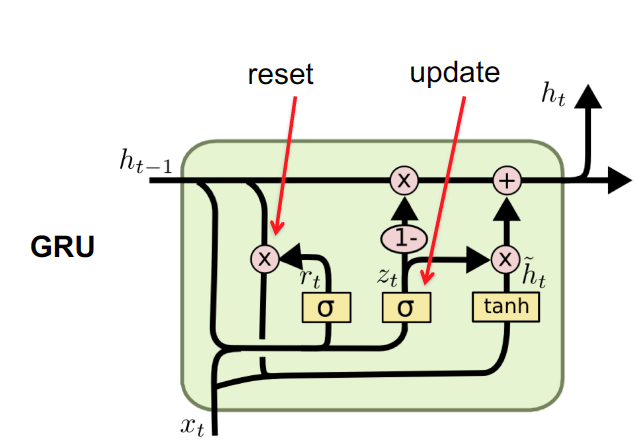

In [ ]:
class GRU_Model(nn.Module):
    def __init__(self, embedding_dim, output_size, hidden_dim, n_layers):
        super(GRU_Model, self).__init__()

        # Defining some parameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # Embedding Layer
        self.emb = nn.Embedding(max_features+1,embedding_dim,padding_idx = 0)
        # RNN Layer
        #self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # LSTM layer 
        #self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                   num_layers=n_layers, batch_first=True)

        #GRU layer 
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=n_layers, batch_first=True)


        # linear layer
        self.fc = nn.Linear(hidden_dim, output_size)
  
    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        embedding = self.emb(x)


        # Passing in the input and hidden state into the model and obtaining outputs
        rnn_out, hidden = self.gru(embedding)
        
        # run_out shape: [bacth_size, sequence length, hidden_dim]
        out = self.fc(rnn_out[:,-1,:])
        
        #we want to use hidden_ as an input for the next layer
        #out = self.fc(hidden)
        

        return out


#### Implement the GRU model

In [ ]:
batch_size = 128

model = GRU_Model(embedding_dim=50, output_size=1, hidden_dim=50, n_layers=1)
summary(model,input_size=(batch_size,maxlen),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRU_Model                                --                        --
├─Embedding: 1-1                         [128, 200, 50]            500,050
├─GRU: 1-2                               [128, 200, 50]            15,300
├─Linear: 1-3                            [128, 1]                  51
Total params: 515,401
Trainable params: 515,401
Non-trainable params: 0
Total mult-adds (M): 455.69
Input size (MB): 0.20
Forward/backward pass size (MB): 20.48
Params size (MB): 2.06
Estimated Total Size (MB): 22.75

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=30,
                      batch_size=128)

Training Start
Epoch:1 / 30, train loss:0.56829 train_acc:0.68961, valid loss:0.46939 valid acc:0.77412
Epoch:2 / 30, train loss:0.40785 train_acc:0.81696, valid loss:0.38561 valid acc:0.82988
Epoch:3 / 30, train loss:0.33186 train_acc:0.85850, valid loss:0.36431 valid acc:0.84794
Epoch:4 / 30, train loss:0.27502 train_acc:0.88528, valid loss:0.31453 valid acc:0.86420
Epoch:5 / 30, train loss:0.22101 train_acc:0.91243, valid loss:0.31290 valid acc:0.86934
Epoch:6 / 30, train loss:0.18112 train_acc:0.92761, valid loss:0.33125 valid acc:0.86826
Epoch:7 / 30, train loss:0.13467 train_acc:0.94699, valid loss:0.37096 valid acc:0.87540
Epoch:8 / 30, train loss:0.09922 train_acc:0.96181, valid loss:0.40417 valid acc:0.86910
Epoch:9 / 30, train loss:0.06811 train_acc:0.97381, valid loss:0.39061 valid acc:0.86982
Epoch:10 / 30, train loss:0.04291 train_acc:0.98390, valid loss:0.46159 valid acc:0.86906
Epoch:11 / 30, train loss:0.03098 train_acc:0.98804, valid loss:0.51261 valid acc:0.87695
Epoc